# Job Search - On-the-Job Search


<a id='index-1'></a>

In [1]:
import numpy as np
import scipy.stats as stats
from interpolation import interp
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline
from math import gamma

In [2]:
class JVWorker:
    r"""
    A Jovanovic-type model of employment with on-the-job search.

    """

    def __init__(self,
                 A=1.4,
                 α=0.6,
                 β=0.96,         # Discount factor
                 π=np.sqrt,      # Search effort function
                 a=2,            # Parameter of f
                 b=2,            # Parameter of f
                 grid_size=50,
                 mc_size=100,
                 ɛ=1e-4):

        self.A, self.α, self.β, self.π = A, α, β, π
        self.mc_size, self.ɛ = mc_size, ɛ

        self.g = njit(lambda x, ϕ: A * (x * ϕ)**α)    # Transition function
        self.f_rvs = np.random.beta(a, b, mc_size)

        # Max of grid is the max of a large quantile value for f and the
        # fixed point y = g(y, 1)
        ɛ = 1e-4
        grid_max = max(A**(1 / (1 - α)), stats.beta(a, b).ppf(1 - ɛ))

        # Human capital
        self.x_grid = np.linspace(ɛ, grid_max, grid_size)

In [3]:
def operator_factory(jv, parallel_flag=True):

    """
    Returns a jitted version of the Bellman operator T

    jv is an instance of JVWorker

    """

    π, β = jv.π, jv.β
    x_grid, ɛ, mc_size = jv.x_grid, jv.ɛ, jv.mc_size
    f_rvs, g = jv.f_rvs, jv.g

    @njit
    def state_action_values(z, x, v):
        s, ϕ = z
        v_func = lambda x: interp(x_grid, v, x)

        integral = 0
        for m in range(mc_size):
            u = f_rvs[m]
            integral += v_func(max(g(x, ϕ), u))
        integral = integral / mc_size

        q = π(s) * integral + (1 - π(s)) * v_func(g(x, ϕ))
        return x * (1 - ϕ - s) + β * q

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """

        v_new = np.empty_like(v)
        for i in prange(len(x_grid)):
            x = x_grid[i]

            # Search on a grid
            search_grid = np.linspace(ɛ, 1, 15)
            max_val = -1
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = state_action_values((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
            v_new[i] = max_val

        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        s_policy, ϕ_policy = np.empty_like(v), np.empty_like(v)

        for i in range(len(x_grid)):
            x = x_grid[i]
            # Search on a grid
            search_grid = np.linspace(ɛ, 1, 15)
            max_val = -1
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = state_action_values((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
                        max_s, max_ϕ = s, ϕ
                        s_policy[i], ϕ_policy[i] = max_s, max_ϕ
        return s_policy, ϕ_policy

    return T, get_greedy

In [4]:
def solve_model(jv,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    """
    Solves the model by value function iteration

    * jv is an instance of JVWorker

    """

    T, _ = operator_factory(jv, parallel_flag=use_parallel)

    # Set up loop
    v = jv.x_grid * 0.5  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [5]:
jv = JVWorker()
T, get_greedy = operator_factory(jv)
v_star = solve_model(jv)
s_star, ϕ_star = get_greedy(v_star)

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


Error at iteration 25 is 0.1511087553476438.
Error at iteration 50 is 0.054459099290115276.
Error at iteration 75 is 0.019626880587201967.
Error at iteration 100 is 0.007073463325795615.
Error at iteration 125 is 0.0025492529594348667.
Error at iteration 150 is 0.0009187423970224984.
Error at iteration 175 is 0.00033111174352740136.
Error at iteration 200 is 0.00011933158528165677.

Converged in 205 iterations.


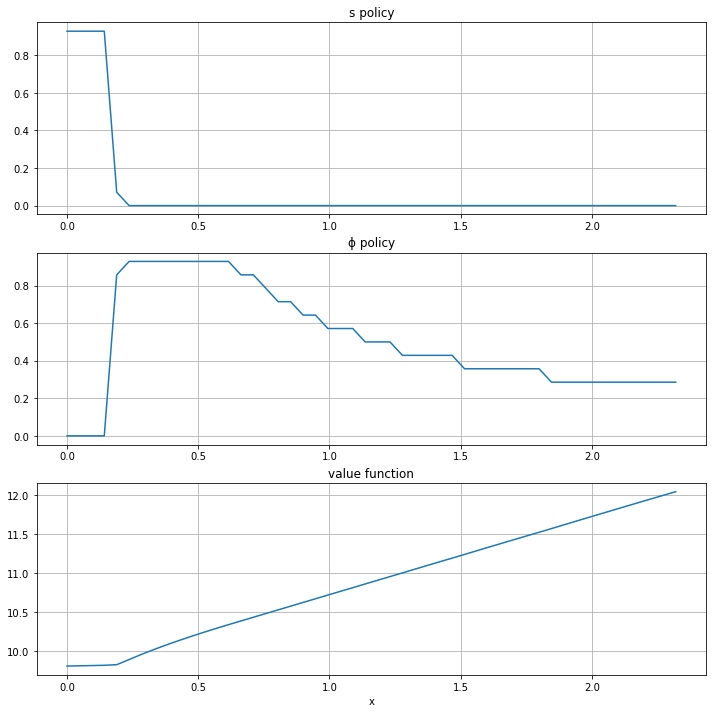

In [6]:
plots = [s_star, ϕ_star, v_star]
titles = ["s policy", "ϕ policy",  "value function"]

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for ax, plot, title in zip(axes, plots, titles):
    ax.plot(jv.x_grid, plot)
    ax.set(title=title)
    ax.grid()

axes[-1].set_xlabel("x")
plt.show()

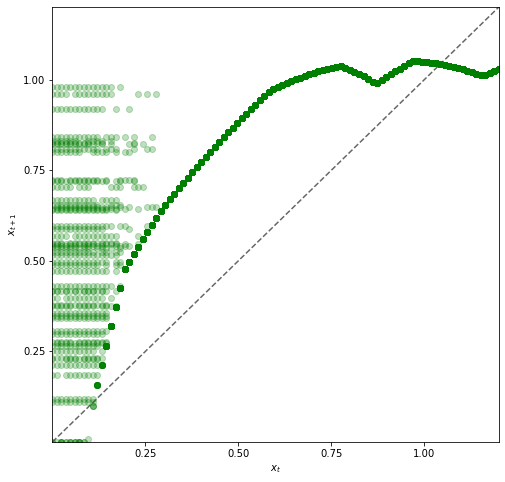

In [7]:
jv = JVWorker(grid_size=25, mc_size=50)
π, g, f_rvs, x_grid = jv.π, jv.g, jv.f_rvs, jv.x_grid
T, get_greedy = operator_factory(jv)
v_star = solve_model(jv, verbose=False)
s_policy, ϕ_policy = get_greedy(v_star)

# Turn the policy function arrays into actual functions
s = lambda y: interp(x_grid, s_policy, y)
ϕ = lambda y: interp(x_grid, ϕ_policy, y)

def h(x, b, u):
    return (1 - b) * g(x, ϕ(x)) + b * max(g(x, ϕ(x)), u)


plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = np.linspace(0, plot_grid_max, plot_grid_size)
fig, ax = plt.subplots(figsize=(8, 8))
ticks = (0.25, 0.5, 0.75, 1.0)
ax.set(xticks=ticks, yticks=ticks,
       xlim=(0, plot_grid_max),
       ylim=(0, plot_grid_max),
       xlabel='$x_t$', ylabel='$x_{t+1}$')

ax.plot(plot_grid, plot_grid, 'k--', alpha=0.6)  # 45 degree line
for x in plot_grid:
    for i in range(jv.mc_size):
        b = 1 if np.random.uniform(0, 1) < π(s(x)) else 0
        u = f_rvs[i]
        y = h(x, b, u)
        ax.plot(x, y, 'go', alpha=0.25)

plt.show()

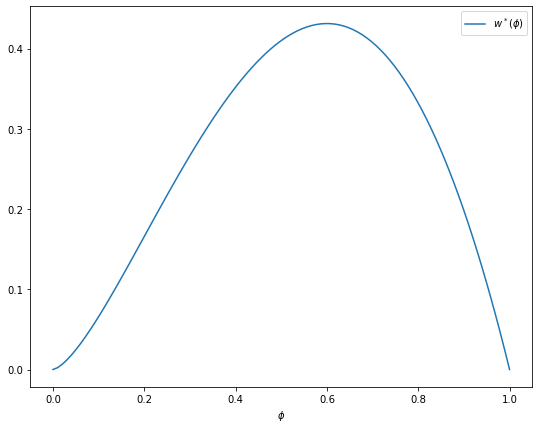

In [8]:
jv = JVWorker()

def xbar(ϕ):
    A, α = jv.A, jv.α
    return (A * ϕ**α)**(1 / (1 - α))

ϕ_grid = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(9, 7))
ax.set(xlabel='$\phi$')
ax.plot(ϕ_grid, [xbar(ϕ) * (1 - ϕ) for ϕ in ϕ_grid], label='$w^*(\phi)$')
ax.legend()

plt.show()